<a href="https://colab.research.google.com/github/PabloNatB/Projects/blob/main/Generar_Imagenes_Ondas_Gravitacionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar las librerías necesarias

In [ ]:
import tensorflow as tf#Librería principal
from matplotlib import pyplot as plt#Graficar
import numpy as np#Para hacer transformaciones
from tensorflow.keras.models import Sequential#Para hacer los modelos del generador y discriminador
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D#Capas de los modelos
from tensorflow.keras.optimizers import Adam#Optimizador de los modelos
from tensorflow.keras.losses import BinaryCrossentropy#Pérdida para calcular el error
from tensorflow.keras.models import Model#Para el callbach
import os#Para la dirección
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback#Hacer la clase de callback

# Cargar y preprocesar los datos

In [ ]:
ds=tf.keras.preprocessing.image_dataset_from_directory(#Función para cargar datasets propios en formato tensorflow
    directory='/content/drive/MyDrive/MachineLearning/Proyecto Final/Data',#Dirección del dataset
    labels='inferred',#Cómo queremos que se clasifiquen las labels
    label_mode='int',#Variable asignada
    class_names=['Blip'],#Nombres de las clases asociadas a cada label
    color_mode='grayscale',#Convertimos a un sólo canal
    batch_size=32,
    image_size=(192,192),
    shuffle=True,
)

Found 256 files belonging to 1 classes.


In [ ]:
for images, labels in ds.take(1):  # Agarramos un batch de 32 imágenes para mostrar
    # Hacmos un grid
    plt.figure(figsize=(12, 12))
    for i in range(16):  # Mostramos 16 imágenes
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convertimos a uint8 para graficar
        plt.axis("off")  # Ocultamos los ejes
    plt.show()

NameError: ignored

In [ ]:
new_dataset = ds.map(lambda x, y: x)  # Quitamos las labels

In [ ]:
# Convertimos los datos para poder normalizarlos
def convert_dtype(element):
    # Con la función cast cambiamos de tf.float32 a tf.uint8
    converted_element = tf.cast(element, tf.uint8)
    return converted_element
# mapeamos la función en todo el dataset
DataSet = new_dataset.map(convert_dtype)

In [ ]:
def norm_img(value):
    img = value#Normalizamos los datos
    return img / 255

In [ ]:
DataSet1=DataSet.map(norm_img)#Normalizamos las imágenes

In [ ]:
DataSet1#Verificamos que el tensor tenga la forma adecuada

<_MapDataset element_spec=TensorSpec(shape=(None, 192, 192, 1), dtype=tf.float32, name=None)>

# Crear DCGAN

# Crear Generador

In [ ]:
def Generator():
    model = Sequential()

    # Genera 3*3*128 numeros aleatorios y los reshape en 3,3,128
    # Beginnings of a generated image
    model.add(Dense(3*3*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((3,3,128)))

    # Duplicamos ancho y alto 1ra vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Duplicamos ancho y alto 2da vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Duplicamos ancho y alto 3ra vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Duplicamos ancho y alto 4ta vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Duplicamos ancho y alto 5ta vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Duplicamos ancho y alto 6ta vez
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Ahora tenemos una imagen 192,192,128

    # 1er Bloque convolucional
    model.add(Conv2D(128, 4,padding='same'))
    model.add(LeakyReLU(0.2))

    # 2do Bloque convolucional
    model.add(Conv2D(128, 4,padding='same'))
    model.add(LeakyReLU(0.2))

    # 3er Bloque convolucional
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # 4to Bloque convolucional
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    # Convertimos a un solo canal
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))#obtener un valor entre 0 y 1

    return model

In [ ]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              148608    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1152)              0         
                                                                 
 reshape (Reshape)           (None, 3, 3, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 6, 6, 128)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 128)         409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 6, 128)         0         
                                                        

## Crear Discriminador

In [ ]:
def Discriminator():
    model = Sequential()#Lo definimos como secuencial

    # 1er Bloque de convolucion
    model.add(Conv2D(32, 5, input_shape = (192,192,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # 2do Bloque de convolucion
    model.add(Conv2D(64, 5, strides=3))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # 3er Bloque de convolucion
    model.add(Conv2D(128, 5, strides=4))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # 4to Bloque de convolucion
    #model.add(Conv2D(256, 5, strides=5))
    #model.add(LeakyReLU(0.2))
    #model.add(Dropout(0.4))


    # Aplanamos y lo pasamos a evaluación, usamos la sigmoide para que la decisión sea binaria
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 188, 188, 32)      832       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 188, 188, 32)      0         
                                                                 
 dropout (Dropout)           (None, 188, 188, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 64)        51264     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 62, 62, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 128)      

##Crear GAN

In [ ]:
g_opt = Adam(learning_rate=0.0001)#Tasa de aprendizaje del generador
d_opt = Adam(learning_rate=0.0000025)#Tasa de aprendizaje del discriminador, es menor a propósito para que el generador tenga oportunidad de aprender bien
g_loss = BinaryCrossentropy()#Usamos BinnayCrossEntropy porque es lo más recomendable en este caso
d_loss = BinaryCrossentropy()

In [ ]:
class GravWavesGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Creamos los atributos del generador y discriminador
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compilar el super class
        super().compile(*args, **kwargs)

        # Crear atributos para la pérdida y optimizadores del generador y discriminador
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Obtenemos el batch de imágenes
        real_images = batch
        fake_images = self.generator(tf.random.normal((32, 128, 1)), training=False)#Generamos 32 imágenes, que son la misma cantidad que el batch, para competir

        #Entrenamos el discriminador
        with tf.GradientTape() as d_tape:
            # Enviamos las imágenes al discriminador
            y_reales_disc = self.discriminator(real_images, training=True)#Imágenes taggeadas como reales yhat_real
            y_falsas_disc = self.discriminator(fake_images, training=True)#Imágenes taggeadas como falsas yhat_fake
            y_totales_disc = tf.concat([y_reales_disc, y_falsas_disc], axis=0)#Las juntamos en un array yhat_realfake

            # Creamos las labels verdaderas para comparar
            y_totales = tf.concat([tf.zeros_like(y_reales_disc), tf.ones_like(y_falsas_disc)], axis=0)#y_realfake

            # Añadimos ruido, esto ayuda al generador
            noise_real = 0.2*tf.random.uniform(tf.shape(y_reales_disc))
            noise_fake = -0.2*tf.random.uniform(tf.shape(y_falsas_disc))
            y_totales += tf.concat([noise_real, noise_fake], axis=0)

            # Calculamos la pérdida con Binnary cross entropy
            perdida_disc = self.d_loss(y_totales, y_totales_disc)

        # Usamos backpropagation para que la red aprenda
        dgrad = d_tape.gradient(perdida_disc, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Entrenar el generador
        with tf.GradientTape() as g_tape:
            # Generamos imágenes
            gen_imgs = self.generator(tf.random.normal((32,128,1)), training=True)

            # les ponemos labels
            y_pred = self.discriminator(gen_imgs, training=False)

            # Calculamos la pérdida
            perdida_gen = self.g_loss(tf.zeros_like(y_pred), y_pred)

        # Aplicamos backpropagation
        ggrad = g_tape.gradient(perdida_gen, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":perdida_disc, "g_loss":perdida_gen}

In [ ]:
modelo = GravWavesGAN(generator, discriminator)#Crear una instancia de la clase Gan

In [ ]:
modelo.compile(g_opt, d_opt, g_loss, d_loss)#compilar el modelo

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255#Desnormalizar
        generated_images.numpy()#Convertir a numpy
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/MachineLearning/Proyecto Final/images/', f'generated_img_{epoch}_{i}.png'))#Guardar las imágenes generadas

## Entrenar, monitorear y guardar modelo

In [ ]:
hist = modelo.fit(DataSet1, epochs=2000, callbacks=[ModelMonitor()])#Entrenar el modelo con 2k épocas

Epoch 1/2000
6/8 [=====================>........] - ETA: 1s - d_loss: 0.6987 - g_loss: 0.6897

8/8 [==============================] - 28s 1s/step - d_loss: 0.6997 - g_loss: 0.6842
Epoch 2/2000
8/8 [==============================] - 8s 954ms/step - d_loss: 0.7129 - g_loss: 0.6545
Epoch 3/2000
8/8 [==============================] - 7s 907ms/step - d_loss: 0.7130 - g_loss: 0.6506
Epoch 4/2000
8/8 [==============================] - 7s 936ms/step - d_loss: 0.7216 - g_loss: 0.6441
Epoch 5/2000
8/8 [==============================] - 7s 913ms/step - d_loss: 0.7213 - g_loss: 0.6403
Epoch 6/2000
8/8 [==============================] - 8s 968ms/step - d_loss: 0.7161 - g_loss: 0.6428
Epoch 7/2000
8/8 [==============================] - 8s 978ms/step - d_loss: 0.7179 - g_loss: 0.6412
Epoch 8/2000
8/8 [==============================] - 7s 912ms/step - d_loss: 0.7214 - g_loss: 0.6409
Epoch 9/2000
8/8 [==============================] - 7s 951ms/step - d_loss: 0.7177 - g_loss: 0.6432
Epoch 10/2000
8/8 [==============================] - 7s 885ms/step - d_loss: 0.7162 - g_loss: 0.6428
Epoch 11/2000


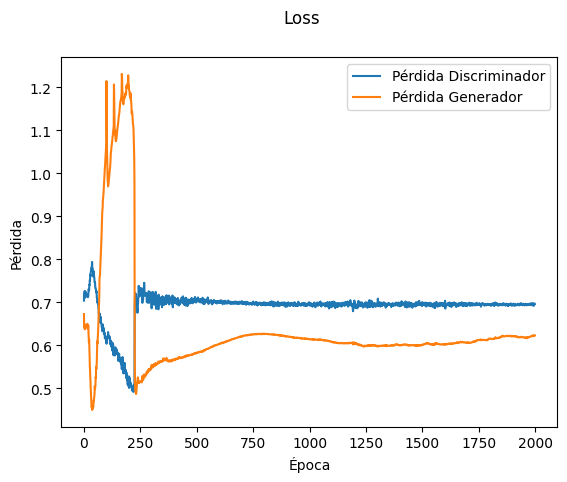

In [ ]:
plt.suptitle('Loss')#Gráfica del modelo
plt.plot(hist.history['d_loss'], label='Pérdida Discriminador')
plt.plot(hist.history['g_loss'], label='Pérdida Generador')
plt.ylabel("Pérdida")
plt.xlabel("Época")
plt.legend()
plt.show()

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))#generar 16 imágenes con el modelo

1/1 [==============================] - 2s 2s/step


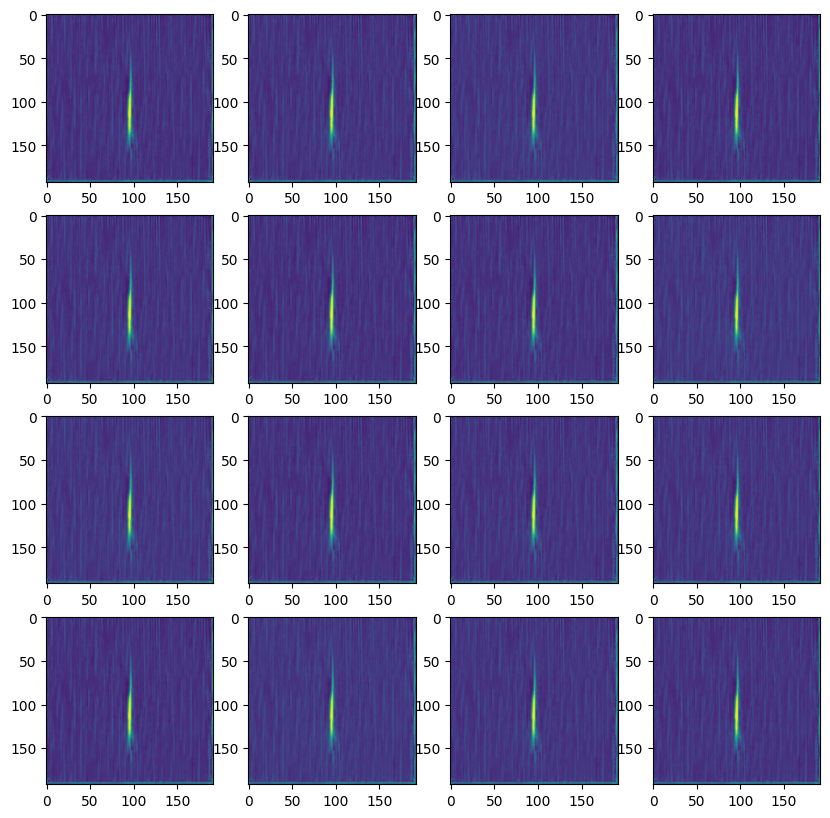

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))#Graficar imágenes generadas por el modelo
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('/content/drive/MyDrive/MachineLearning/Proyecto Final/models/generator.h5')#guardar generador
discriminator.save('/content/drive/MyDrive/MachineLearning/Proyecto Final/models/discriminator.h5') #guardar discriminador

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
